In [15]:


import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tomato:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F259770%2F544347%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240624%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240624T085602Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D50732c30bd04da2003e70c4169a1e15104f550e44db316ae832262a0a50a9f7b36f5eadc7c46054304a9ac2ceac496dae45549e83143ca80f3c3c8caaf68874ab1d03cff230fae730cadad138383951bb89798025333efb53048e71a6f27f529663c8a68f09d03ed6113b0e299353c3f6c0189d6aee8a7d1d69b7887dbbc5bf79dd12a73d24cc3732afdff39ace236bf9b296e9c8dd812bc2a8d217963c8bc96f93a41147dec60ccd8cb1d167f2490c347081c9de9c623b37a7cd6e614fbfcc211bbc875b96024c9db4ff18035aefab34d743258841b04238bfada34ad671c75976e2804e366c02fbc94ad9cb7407d1ba479d9313cbafa2bbc474a0942312cfb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 778959748 bytes downloaded
Downloaded and uncompressed: tomato
Data source import complete.


## Transfer Learning ResNet152v2 using Keras

Please download the dataset from the below url

In [16]:
# import the libraries as shown below
import tensorflow

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [17]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '../input/tomato/New Plant Diseases Dataset(Augmented)/train/'
valid_path = '../input/tomato/New Plant Diseases Dataset(Augmented)/valid/'


In [18]:

resnet152V2 = ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)



In [19]:
# don't train existing weights
for layer in resnet152V2.layers:
    layer.trainable = False

In [20]:
  # useful for getting number of output classes
folders = glob('../input/tomato/New Plant Diseases Dataset(Augmented)/train/*')

In [21]:
from tensorflow.keras.layers import GlobalAveragePooling2D
x = GlobalAveragePooling2D()(resnet152V2.output)

In [22]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet152V2.input, outputs=prediction)

In [23]:

# view the structure of the model
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [24]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [25]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [26]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('../input/tomato/New Plant Diseases Dataset(Augmented)/train/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 18345 images belonging to 10 classes.


In [27]:
test_set = test_datagen.flow_from_directory('../input/tomato/New Plant Diseases Dataset(Augmented)/valid/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4585 images belonging to 10 classes.


In [28]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=16,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-28-d0c10fc4f92e>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/16
574/574 [==============================] - 330s 542ms/step - loss: 0.7682 - accuracy: 0.7555 - val_loss: 0.5228 - val_accuracy: 0.8314
Epoch 2/16
574/574 [==============================] - 309s 538ms/step - loss: 0.4234 - accuracy: 0.8651 - val_loss: 0.3803 - val_accuracy: 0.8818
Epoch 3/16
574/574 [==============================] - 308s 537ms/step - loss: 0.3409 - accuracy: 0.8918 - val_loss: 0.3071 - val_accuracy: 0.9016
Epoch 4/16
574/574 [==============================] - 307s 534ms/step - loss: 0.2955 - accuracy: 0.9062 - val_loss: 0.2800 - val_accuracy: 0.9056
Epoch 5/16
574/574 [==============================] - 307s 535ms/step - loss: 0.2671 - accuracy: 0.9135 - val_loss: 0.2815 - val_accuracy: 0.9053
Epoch 6/16
574/574 [==============================] - 313s 545ms/step - loss: 0.2478 - accuracy: 0.9186 - val_loss: 0.2594 - val_accuracy: 0.9149
Epoch 7/16
574/574 [==============================] - 305s 532ms/step - loss: 0.2305 - accuracy: 0.9249 - val_loss: 0.2373 -

In [29]:
import matplotlib.pyplot as plt

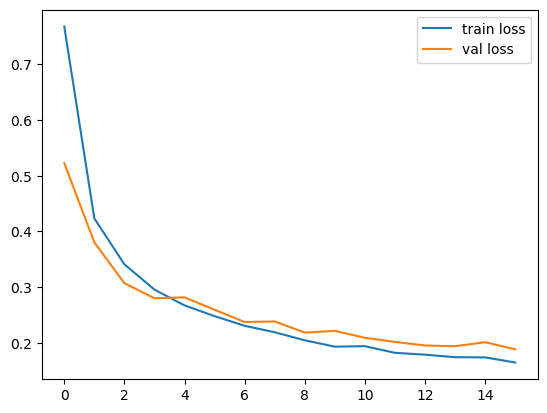

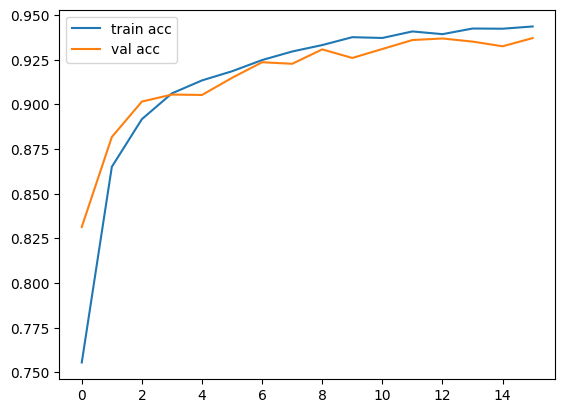

<Figure size 640x480 with 0 Axes>

In [30]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [31]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet152V2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:

y_pred = model.predict(test_set)


144/144 [==============================] - 36s 223ms/step


In [33]:
y_pred

array([[1.56621580e-12, 9.00801300e-09, 3.74363518e-09, ...,
        1.00584796e-09, 1.22320010e-11, 9.99876976e-01],
       [4.51451898e-09, 9.91425276e-01, 8.57150275e-03, ...,
        2.75643869e-10, 6.94798663e-11, 7.99019054e-15],
       [3.46824690e-03, 6.81522535e-04, 1.55374757e-03, ...,
        8.87867585e-02, 1.95631618e-03, 1.04096776e-04],
       ...,
       [2.86264196e-07, 6.49100423e-01, 3.36534023e-01, ...,
        1.00985483e-06, 2.04871675e-08, 4.66473882e-09],
       [3.94243607e-03, 8.32713122e-05, 1.78189285e-03, ...,
        3.31571136e-05, 2.37100867e-05, 8.37631433e-07],
       [1.99225418e-08, 1.97832615e-05, 1.39930455e-06, ...,
        2.71279155e-09, 9.99247670e-01, 3.75611720e-08]], dtype=float32)

In [34]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [35]:
y_pred

array([9, 1, 3, ..., 1, 3, 8])

In [45]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [48]:
model=load_model('/content/model_resnet152V2.h5')

In [49]:
img_data

NameError: name 'img_data' is not defined

In [39]:
img=image.load_img('../input/tomato/New Plant Diseases Dataset(Augmented)/valid/Tomato___Bacterial_spot/014b58ae-091b-408a-ab4a-5a780cd1c3f3___GCREC_Bact.Sp 2971.JPG',target_size=(224,224))



In [40]:
x=image.img_to_array(img)
x

In [41]:
 x.shape

In [42]:
 x=x/255

In [43]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='global_average_pooling2d_1/Mean:0', description="created by layer 'global_average_pooling2d_1'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.

In [ ]:
model.predict(img_data)

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)

In [ ]:
a==1

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__